Task: beat "A2 baseline (10 credits)" on Public LB (0.75914 LB score)

This notebook based on [Catboost starter](https://www.kaggle.com/kashnitsky/mlcourse-ai-fall-2019-catboost-starter)

In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (18,9)
from tqdm import tqdm
import seaborn as sns

In [2]:
def create_submission(test_pred, file_name='my_submission.csv'):
    sample_submission = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', index_col = 'id')
    sample_submission['dep_delayed_15min'] = test_pred
    sample_submission.to_csv(file_name)

Read the data

In [99]:
PATH_TO_DATA = Path(r'../../data/flight-delays-fall-2018/')

In [311]:
train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')

In [312]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [313]:
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')

In [314]:
test_df.tail()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
99995,c-6,c-5,c-2,852,WN,CRP,HOU,187
99996,c-11,c-24,c-6,1446,UA,ORD,LAS,1515
99997,c-1,c-30,c-2,1509,OO,ORD,SGF,438
99998,c-1,c-5,c-5,804,DL,LGA,ATL,761
99999,c-10,c-29,c-1,834,OO,MKE,MSP,297


In [963]:
# train_df: UniqueCarrier-22, Origin-289, Dest-289
# test_df: UniqueCarrier-20, Origin-300, Dest-298
# len(train_df['DayofMonth'].unique())

In [8]:
train_df['dep_delayed_15min'].value_counts()

N    80956
Y    19044
Name: dep_delayed_15min, dtype: int64

Features processing

In [315]:
train_df['Month'] = train_df['Month'].str.replace('c-','').astype('int64')
train_df['DayofMonth'] = train_df['DayofMonth'].str.replace('c-','').astype('int64')
train_df['DayOfWeek'] = train_df['DayOfWeek'].str.replace('c-','').astype('int64')

test_df['Month'] = test_df['Month'].str.replace('c-','').astype('int64')
test_df['DayofMonth'] = test_df['DayofMonth'].str.replace('c-','').astype('int64')
test_df['DayOfWeek'] = test_df['DayOfWeek'].str.replace('c-','').astype('int64')

In [316]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  int64 
 1   DayofMonth         100000 non-null  int64 
 2   DayOfWeek          100000 non-null  int64 
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


Visual Analysis

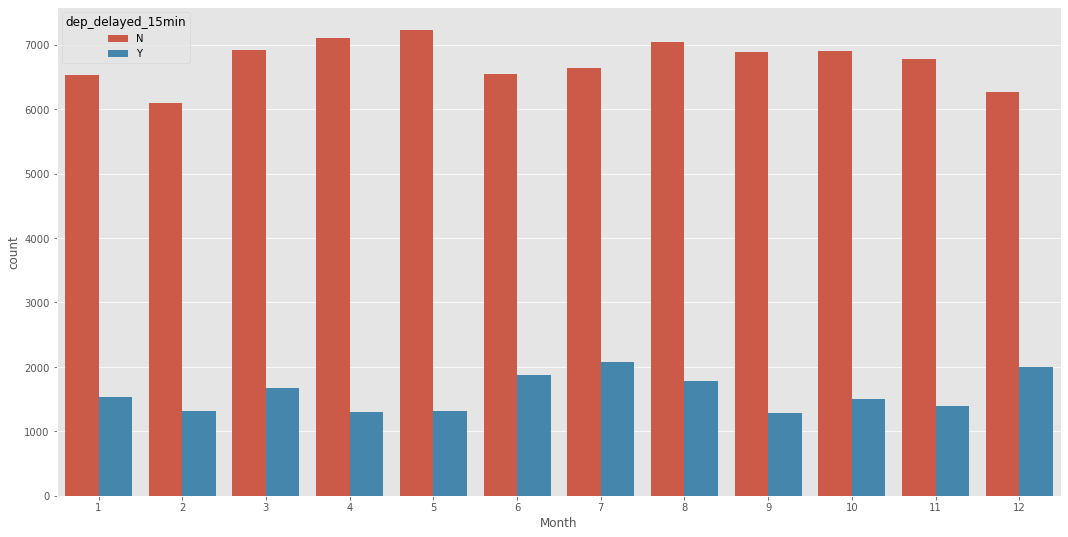

In [97]:
sns.countplot(data=train_df, x='Month', hue='dep_delayed_15min');

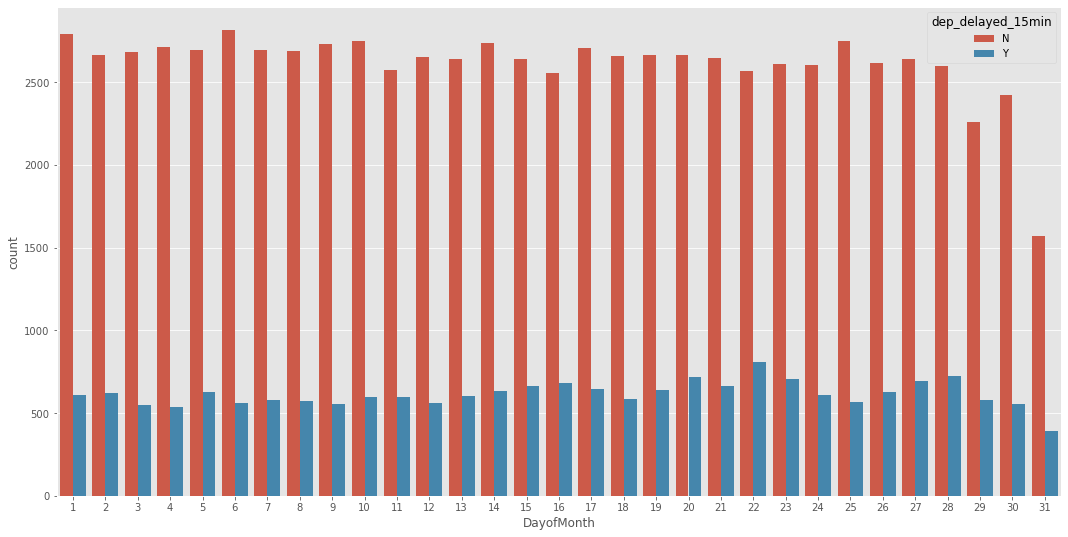

In [317]:
sns.countplot(data=train_df, x='DayofMonth', hue='dep_delayed_15min');

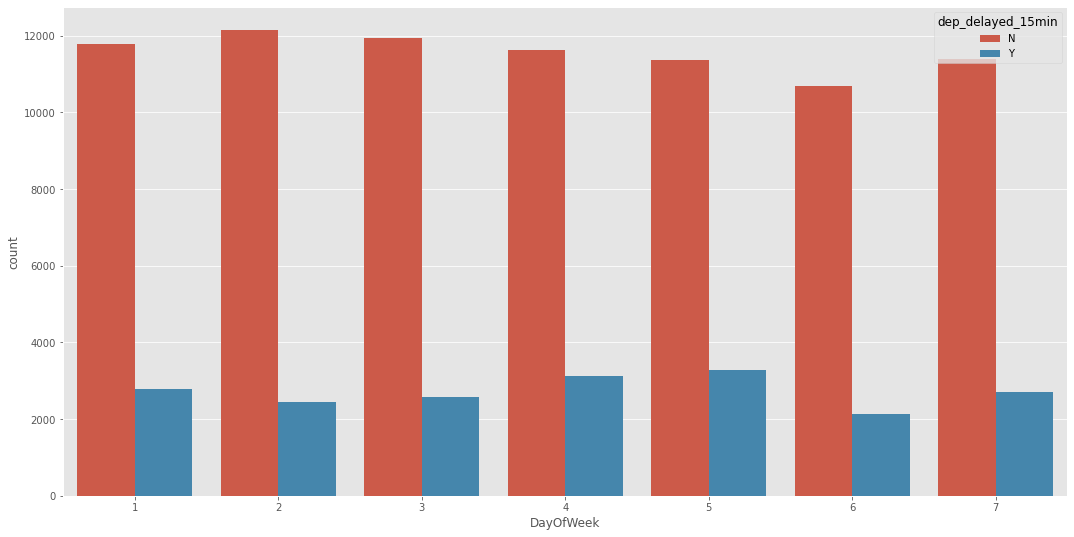

In [99]:
sns.countplot(data=train_df, x='DayOfWeek', hue='dep_delayed_15min');

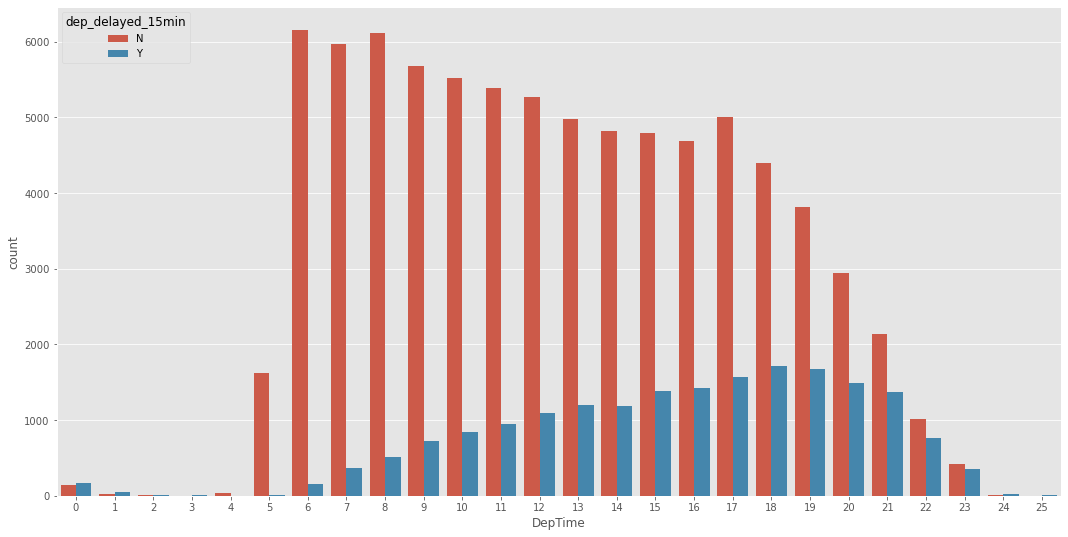

In [100]:
sns.countplot((train_df["DepTime"]/100).astype('int64'), hue=train_df["dep_delayed_15min"]);

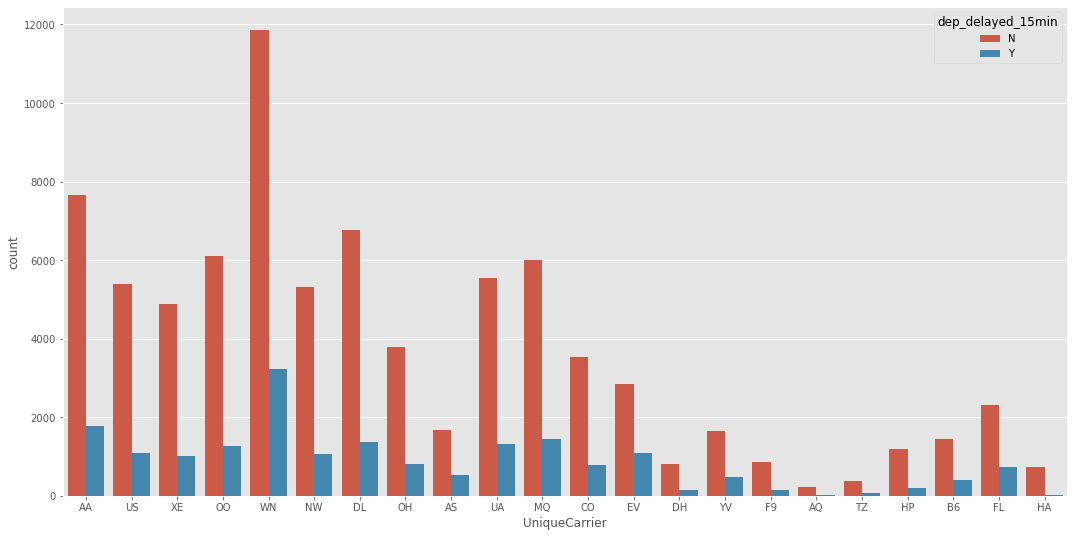

In [101]:
sns.countplot(data=train_df, x='UniqueCarrier', hue='dep_delayed_15min');

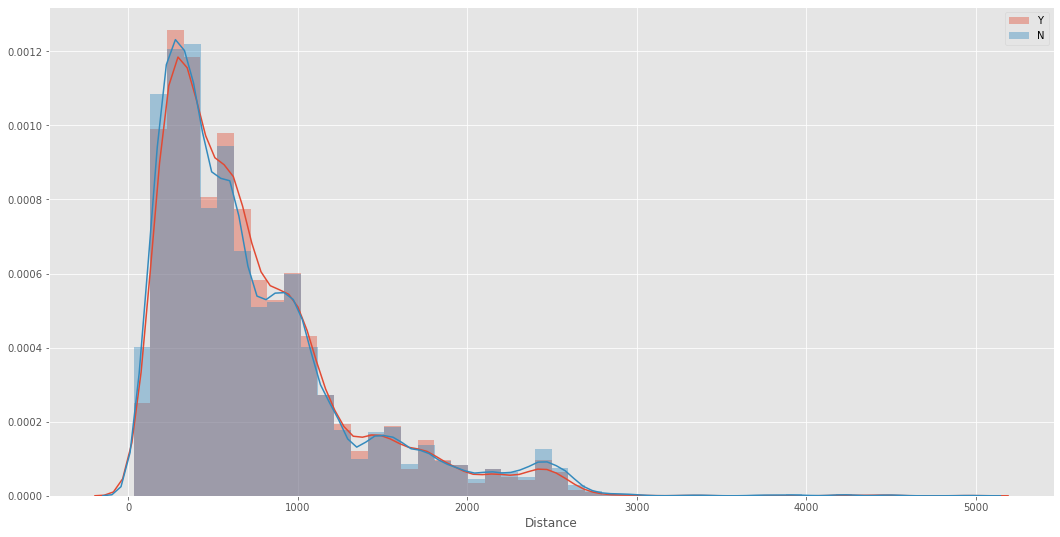

In [102]:
sns.distplot(train_df.loc[train_df["dep_delayed_15min"] == "Y"]["Distance"])
sns.distplot(train_df.loc[train_df["dep_delayed_15min"] == "N"]["Distance"])
plt.legend(labels=['Y', 'N']);

Create features

In [318]:
# feature 'Origin_Dest'
train_df['Origin_Dest'] = train_df['Origin'] + '_' + train_df['Dest']
test_df['Origin_Dest'] = test_df['Origin'] + '_' + test_df['Dest']

In [319]:
# feature 'season'
seasons_map = {12: 'winter', 1: 'winter', 2: 'winter',
               3: 'spring', 4: 'spring', 5: 'spring',
               6: 'summer', 7: 'summer',8: 'summer',
               9: 'autumn', 10: 'autumn', 11: 'autumn'
              }
train_df['Season'] = train_df['Month'].map(seasons_map)
test_df['Season'] = test_df['Month'].map(seasons_map)

In [264]:
# # feature 'month_period'
# def month_period(day):
#     if 0 < day < 11:
#         return 'start'
#     elif 10 < day < 21:
#         return 'middle'
#     elif 20 < day < 32:
#         return 'finish'
    
# train_df['Month_period'] = train_df['DayofMonth'].apply(month_period)
# test_df['Month_period'] = test_df['DayofMonth'].apply(month_period)

In [265]:
# # feature 'workday'
# train_df['Workday'] = train_df['DayOfWeek'].apply(lambda x: 'True' if x < 6 else 'False')
# test_df['Workday'] = test_df['DayOfWeek'].apply(lambda x: 'True' if x < 6 else 'False')

In [320]:
# feature 'weekend'
train_df['Weekend'] = train_df['DayOfWeek'].apply(lambda x: 'False' if x < 6 else 'True')
test_df['Weekend'] = test_df['DayOfWeek'].apply(lambda x: 'False' if x < 6 else 'True')

In [321]:
# feature 'daytime'
def daytime(hour):
    if hour == 24: 
        hour = 0
    elif hour == 25:
        hour = 1
        
    if 6 < hour < 13:
        return 'morning'
    elif 12 < hour < 19:
        return 'day'
    elif 18 < hour < 24:
        return 'evening'    
    elif 0 <= hour < 7:
        return 'night'
    
train_df['Daytime'] = (train_df['DepTime']/100).astype('int64').apply(daytime)
test_df['Daytime'] = (test_df['DepTime']/100).astype('int64').apply(daytime)

In [322]:
# feature Dep_hour
train_df['Dep_hour'] = (train_df['DepTime']/100).astype('int64')
test_df['Dep_hour'] = (test_df['DepTime']/100).astype('int64')

train_df.loc[train_df['Dep_hour'] == 24, 'Dep_hour'] = 0
train_df.loc[train_df['Dep_hour'] == 25, 'Dep_hour'] = 1

test_df.loc[train_df['Dep_hour'] == 24, 'Dep_hour'] = 0
test_df.loc[train_df['Dep_hour'] == 25, 'Dep_hour'] = 1

In [323]:
# Dep_hour_bin
def dep_hour_bin(hour):
    if hour == 24: 
        hour = 0
    elif hour == 25:
        hour = 1
        
    if 0 <= hour < 3:
        return '0-2'
    elif 2 < hour < 6:
        return '3-5'
    elif 5 < hour < 9:
        return '6-8'    
    elif 8 < hour < 12:
        return '9-11'
    elif 11 < hour < 15:
        return '12-14'
    elif 14 < hour < 18:
        return '15-17'
    elif 17 < hour < 21:
        return '18-20'
    elif 20 < hour < 24:
        return '21-23'
    
train_df['Dep_hour_bin'] = (train_df['DepTime']/100).astype('int64').apply(dep_hour_bin)
test_df['Dep_hour_bin'] = (test_df['DepTime']/100).astype('int64').apply(dep_hour_bin)

In [324]:
# feature 'distance_bin'
def distance_bin(distance):    
    if 0 < distance < 501:
        return '0-500'
    elif 500 < distance < 1001:
        return '501-1000'
    elif 1000 < distance < 1501:
        return '1001-1500'
    elif 1500 < distance < 2001:
        return '1501-2000'
    elif 2000 < distance < 2501:
        return '2001-2500'
    elif 2500 < distance < 3001:
        return '2501-3000'
    elif 3000 < distance:
        return '3001-...'

train_df['distance_bin'] = train_df['Distance'].apply(distance_bin)
test_df['distance_bin'] = test_df['Distance'].apply(distance_bin)

In [325]:
# Dep_hour_2, Dep_hour_4
train_df['Dep_hour_2'] = (train_df['Dep_hour']**2).astype(str)
test_df['Dep_hour_2'] = (test_df['Dep_hour']**2).astype(str)

train_df['Dep_hour_4'] = (train_df['Dep_hour']**4).astype(str)
test_df['Dep_hour_4'] = (test_df['Dep_hour']**4).astype(str)

In [193]:
# Dep_hour_3
# train_df['Dep_hour_3'] = (train_df['Dep_hour']**3).astype(str)
# test_df['Dep_hour_3'] = (test_df['Dep_hour']**3).astype(str)

In [326]:
# Dep_minute
train_df['Dep_minute'] = (train_df['DepTime'] % 100)
test_df['Dep_minute'] = (test_df['DepTime'] % 100)

In [296]:
# train_df['Dep_minute_2'] = (train_df['Dep_minute']**2).astype(str)
# test_df['Dep_minute_2'] = (test_df['Dep_minute']**2).astype(str)

In [327]:
# season OHE: winter, spring, summer, autumn
train_df['Winter'] = train_df['Season'] == 'winter'
test_df['Winter'] = test_df['Season'] == 'winter'

train_df['Spring'] = train_df['Season'] == 'spring'
test_df['Spring'] = test_df['Season'] == 'spring'

train_df['Summer'] = train_df['Season'] == 'summer'
test_df['Summer'] = test_df['Season'] == 'summer'

train_df['Autumn'] = train_df['Season'] == 'autumn'
test_df['Autumn'] = test_df['Season'] == 'autumn'

Features from catboost feature interactions importance

In [136]:
# feature DepTime_Origin
train_df['DepTime_Origin'] = train_df['DepTime'].astype(str) + '_' + train_df['Origin']
test_df['DepTime_Origin'] = test_df['DepTime'].astype(str) + '_' + test_df['Origin']

In [138]:
# feature DepTime_Distance
train_df['DepTime_Distance'] = train_df['DepTime'].astype(str) + '_' + train_df['Distance'].astype(str)
test_df['DepTime_Distance'] = test_df['DepTime'].astype(str) + '_' + test_df['Distance'].astype(str)

In [141]:
# feature Month_DayofMonth
train_df['Month_DayofMonth'] = train_df['Month'].astype(str) + '_' + train_df['DayofMonth'].astype(str)
test_df['Month_DayofMonth'] = test_df['Month'].astype(str) + '_' + test_df['DayofMonth'].astype(str)

In [139]:
# feature DepTime_UniqueCarrier
train_df['DepTime_UniqueCarrier'] = train_df['DepTime'].astype(str) + '_' + train_df['UniqueCarrier']
test_df['DepTime_UniqueCarrier'] = test_df['DepTime'].astype(str) + '_' + test_df['UniqueCarrier']

In [140]:
# feature DepTime_Origin_Dest
train_df['DepTime_Origin_Dest'] = train_df['DepTime'].astype(str) + '_' + train_df['Origin_Dest']
test_df['DepTime_Origin_Dest'] = test_df['DepTime'].astype(str) + '_' + test_df['Origin_Dest']

In [328]:
# feature UniqueCarrier_Dest
train_df['UniqueCarrier_Dest'] = train_df['UniqueCarrier']  + '_' +  train_df['Dest']
test_df['UniqueCarrier_Dest'] = test_df['UniqueCarrier']  + '_' +  test_df['Dest']

In [161]:
# feature DepTime_Dest
train_df['DepTime_Dest'] = train_df['DepTime'].astype(str) + '_' + train_df['Dest']
test_df['DepTime_Dest'] = test_df['DepTime'].astype(str) + '_' + test_df['Dest']

In [ ]:
# feature Month_Dest
train_df['Month_Dest'] = train_df['Month'].astype(str) + '_' + train_df['Dest']
test_df['Month_Dest'] = test_df['Month'].astype(str) + '_' + test_df['Dest']

In [176]:
# Month_Origin
train_df['Month_Origin'] = train_df['Month'].astype(str) + '_' + train_df['Origin']
test_df['Month_Origin'] = test_df['Month'].astype(str) + '_' + test_df['Origin']

In [177]:
# Month_UniqueCarrier
train_df['Month_UniqueCarrier'] = train_df['Month'].astype(str) + '_' + train_df['UniqueCarrier']
test_df['Month_UniqueCarrier'] = test_df['Month'].astype(str) + '_' + test_df['UniqueCarrier']

In [179]:
# Month_DayOfWeek
train_df['Month_DayOfWeek'] = train_df['Month'].astype(str) + '_' + train_df['DayOfWeek'].astype(str)
test_df['Month_DayOfWeek'] = test_df['Month'].astype(str) + '_' + test_df['DayOfWeek'].astype(str)

In [180]:
# Month_DepTime
train_df['Month_DepTime'] = train_df['Month'].astype(str) + '_' + train_df['DepTime'].astype(str)
test_df['Month_DepTime'] = test_df['Month'].astype(str) + '_' + test_df['DepTime'].astype(str)

In [181]:
# DayofMonth_Dest
train_df['DayofMonth_Dest'] = train_df['DayofMonth'].astype(str) + '_' + train_df['Dest']
test_df['DayofMonth_Dest'] = test_df['DayofMonth'].astype(str) + '_' + test_df['Dest']

In [329]:
# UniqueCarrier_Origin
train_df['UniqueCarrier_Origin'] = train_df['UniqueCarrier'] + '_' + train_df['Origin']
test_df['UniqueCarrier_Origin'] = test_df['UniqueCarrier'] + '_' + test_df['Origin']

In [354]:
# UniqueCarrier_Origin_Dest
train_df['UniqueCarrier_Origin_Dest'] = train_df['UniqueCarrier'] + '_' + train_df['Origin_Dest']
test_df['UniqueCarrier_Origin_Dest'] = test_df['UniqueCarrier'] + '_' + test_df['Origin_Dest']

In [185]:
# UniqueCarrier_Daytime
train_df['UniqueCarrier_Daytime'] = train_df['UniqueCarrier'] + '_' + train_df['Daytime'].astype(str)
test_df['UniqueCarrier_Daytime'] = test_df['UniqueCarrier'] + '_' + test_df['Daytime'].astype(str)

In [186]:
# Dest_Daytime
train_df['Dest_Daytime'] = train_df['Dest'] + '_' + train_df['Daytime'].astype(str)
test_df['Dest_Daytime'] = test_df['Dest'] + '_' + test_df['Daytime'].astype(str)

In [187]:
# Dest_Distance
train_df['Dest_Distance'] = train_df['Dest'] + '_' + train_df['Distance'].astype(str)
test_df['Dest_Distance'] = test_df['Dest'] + '_' + test_df['Distance'].astype(str)

In [188]:
# DayOfWeek_Dest
train_df['DayOfWeek_Dest'] = train_df['DayOfWeek'].astype(str) + '_' + train_df['Dest']
test_df['DayOfWeek_Dest'] = test_df['DayOfWeek'].astype(str) + '_' + test_df['Dest']

In [189]:
# DayofMonth_Origin
train_df['DayofMonth_Origin'] = train_df['DayofMonth'].astype(str) + '_' + train_df['Origin']
test_df['DayofMonth_Origin'] = test_df['DayofMonth'].astype(str) + '_' + test_df['Origin']

In [402]:
# Origin_Dest_Dep_minute
train_df['Origin_Dest_Dep_minute'] = train_df['Origin_Dest'] + '_' + train_df['Dep_minute'].astype(str)
test_df['Origin_Dest_Dep_minute'] = test_df['Origin_Dest'] + '_' + test_df['Dep_minute'].astype(str)

In [426]:
# Origin_Dest_Dep_hour
train_df['Origin_Dest_Dep_hour'] = train_df['Origin_Dest'] + '_' + train_df['Dep_hour']
test_df['Origin_Dest_Dep_hour'] = test_df['Origin_Dest'] + '_' + test_df['Dep_hour']

In [458]:
# Dest_UniqueCarrier_Origin
train_df['Dest_UniqueCarrier_Origin'] = train_df['Dest'] + '_' + train_df['UniqueCarrier_Origin']
test_df['Dest_UniqueCarrier_Origin'] = test_df['Dest'] + '_' + test_df['UniqueCarrier_Origin']

Metrical to categorical

In [70]:
# train_df['Month'] = train_df['Month'].astype(str)
# test_df['Month'] = test_df['Month'].astype(str)

In [71]:
# train_df['DayofMonth'] = train_df['DayofMonth'].astype(str)
# test_df['DayofMonth'] = test_df['DayofMonth'].astype(str)

In [72]:
# train_df['DayOfWeek'] = train_df['DayOfWeek'].astype(str)
# test_df['DayOfWeek'] = test_df['DayOfWeek'].astype(str)

In [336]:
train_df['Dep_hour'] = train_df['Dep_hour'].astype(str)
test_df['Dep_hour'] = test_df['Dep_hour'].astype(str)

# # train_df['Dep_hour'] = train_df['Dep_hour'].astype('int64')
# # test_df['Dep_hour'] = test_df['Dep_hour'].astype('int64')

In [143]:
# train_df['Dep_minute'] = train_df['Dep_minute'].astype('int64')
# test_df['Dep_minute'] = test_df['Dep_minute'].astype('int64')

In [459]:
train_df.columns, len(train_df.columns)

(Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
        'Origin', 'Dest', 'Distance', 'dep_delayed_15min', 'Origin_Dest',
        'Season', 'Weekend', 'Daytime', 'Dep_hour', 'Dep_hour_bin',
        'distance_bin', 'Dep_hour_2', 'Dep_hour_4', 'Dep_minute', 'Winter',
        'Spring', 'Summer', 'Autumn', 'UniqueCarrier_Dest',
        'UniqueCarrier_Origin', 'UniqueCarrier_Origin_Dest',
        'Origin_Dest_Dep_minute', 'Origin_Dest_Dep_hour',
        'Dest_UniqueCarrier_Origin'],
       dtype='object'),
 29)

In [460]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Month                      100000 non-null  int64 
 1   DayofMonth                 100000 non-null  int64 
 2   DayOfWeek                  100000 non-null  int64 
 3   DepTime                    100000 non-null  int64 
 4   UniqueCarrier              100000 non-null  object
 5   Origin                     100000 non-null  object
 6   Dest                       100000 non-null  object
 7   Distance                   100000 non-null  int64 
 8   dep_delayed_15min          100000 non-null  object
 9   Origin_Dest                100000 non-null  object
 10  Season                     100000 non-null  object
 11  Weekend                    100000 non-null  object
 12  Daytime                    100000 non-null  object
 13  Dep_hour                   100000 non-null  o

In [461]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Origin_Dest,Season,...,Winter,Spring,Summer,Autumn,UniqueCarrier_Dest,UniqueCarrier_Origin,UniqueCarrier_Origin_Dest,Origin_Dest_Dep_minute,Origin_Dest_Dep_hour,Dest_UniqueCarrier_Origin
0,7,25,3,615,YV,MRY,PHX,598,MRY_PHX,summer,...,False,False,True,False,YV_PHX,YV_MRY,YV_MRY_PHX,MRY_PHX_15,MRY_PHX_6,PHX_YV_MRY
1,4,17,2,739,WN,LAS,HOU,1235,LAS_HOU,spring,...,False,True,False,False,WN_HOU,WN_LAS,WN_LAS_HOU,LAS_HOU_39,LAS_HOU_7,HOU_WN_LAS
2,12,2,7,651,MQ,GSP,ORD,577,GSP_ORD,winter,...,True,False,False,False,MQ_ORD,MQ_GSP,MQ_GSP_ORD,GSP_ORD_51,GSP_ORD_6,ORD_MQ_GSP
3,3,25,7,1614,WN,BWI,MHT,377,BWI_MHT,spring,...,False,True,False,False,WN_MHT,WN_BWI,WN_BWI_MHT,BWI_MHT_14,BWI_MHT_16,MHT_WN_BWI
4,6,6,3,1505,UA,ORD,STL,258,ORD_STL,summer,...,False,False,True,False,UA_STL,UA_ORD,UA_ORD_STL,ORD_STL_5,ORD_STL_15,STL_UA_ORD


Feature pairs interactions

In [246]:
# train_df_interact = train_df.drop('dep_delayed_15min', axis=1).copy()
# test_df_interact = test_df.copy()

In [247]:
# cat_features = train_df_interact.columns[train_df_interact.dtypes == 'object']
# for i, col1 in enumerate(cat_features):
#     for j, col2 in enumerate(cat_features[i + 1:]):
#         train_df_interact[col1 + '_' + col2] = train_df_interact[col1] + '_' + train_df_interact[col2]
#         test_df_interact[col1 + '_' + col2] = test_df_interact[col1] + '_' + test_df_interact[col2]

In [248]:
# train_df_interact.shape, test_df_interact.shape

((100000, 81), (100000, 81))

One Hot Encoding

In [83]:
# %%time

# df = pd.concat([train_df.drop('dep_delayed_15min', axis=1), test_df])
# print(df.shape)

# df_cat_dummies = pd.get_dummies(df, columns=df.columns[df.dtypes == 'object'])
# print(df_cat_dummies.shape)

(200000, 5737)

In [146]:
# train_df_cat_dummies = df_cat_dummies.iloc[:train_df.shape[0],:]
# train_df_cat_dummies.shape

(100000, 5737)

In [143]:
# test_df_cat_dummies = df_cat_dummies.iloc[train_df.shape[0]:,:]
# test_df_cat_dummies.shape

(100000, 5737)

In [828]:
# train_df_cat_dummies.columns
# # train_df_cat_dummies.dtypes == 'object'

Scaling

In [335]:
# scaler = StandardScaler()

# train_df[['DepTime', 'Distance']] = scaler.fit_transform(train_df[['DepTime', 'Distance']])
# test_df[['DepTime', 'Distance']] = scaler.transform(test_df[['DepTime', 'Distance']])

# # train_df_interact[['DepTime', 'Distance']] = scaler.fit_transform(train_df_interact[['DepTime', 'Distance']])
# # test_df_interact[['DepTime', 'Distance']] = scaler.transform(test_df_interact[['DepTime', 'Distance']])


Dataset is imbalanced. Calculate ratio for classes

In [26]:
# ratio = float(np.sum(train_df['dep_delayed_15min'] == 'N')) / np.sum(np.sum(train_df['dep_delayed_15min'] == 'Y'))
# class_weights=[1, ratio]
# class_weights

[1, 4.250997689561016]

Remember indexes of categorical features (to be passed to Catboost)

In [483]:
columns_to_drop = ['dep_delayed_15min', 'DepTime', 'Distance', 'Season', 'Origin_Dest_Dep_hour']

cat_feat_idx = np.where(train_df.drop(columns_to_drop, axis=1).dtypes != 'int64')[0]

# cat_feat_idx = np.where(train_df_interact.drop('DepTime', axis=1).dtypes == 'object')[0].tolist()
cat_feat_idx, len(cat_feat_idx)

(array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
        21, 22, 23], dtype=int64),
 20)

In [484]:
train_df.drop(columns_to_drop, axis=1).info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   Month                      100000 non-null  int64 
 1   DayofMonth                 100000 non-null  int64 
 2   DayOfWeek                  100000 non-null  int64 
 3   UniqueCarrier              100000 non-null  object
 4   Origin                     100000 non-null  object
 5   Dest                       100000 non-null  object
 6   Origin_Dest                100000 non-null  object
 7   Weekend                    100000 non-null  object
 8   Daytime                    100000 non-null  object
 9   Dep_hour                   100000 non-null  object
 10  Dep_hour_bin               100000 non-null  object
 11  distance_bin               100000 non-null  object
 12  Dep_hour_2                 100000 non-null  object
 13  Dep_hour_4                 100000 non-null  o

#### Allocate validation (hold out) set to validate the model

In [485]:
X_train = train_df.drop(columns_to_drop, axis=1).values
# X_train = train_df_interact.drop('DepTime', axis=1)

y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

X_test = test_df.drop(columns_to_drop[1:], axis=1).values
# X_test = test_df_interact

X_train.shape, X_test.shape

((100000, 24), (100000, 24))

In [486]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train
                                                                , test_size=0.2
#                                                                 , stratify=y_train
                                                                , random_state=1)

In [487]:
X_train_part.shape

(80000, 24)

Train Catboost, passing only the indexes of categorical features

In [488]:
# ctb = CatBoostClassifier(task_type='GPU', random_seed=17, silent=True) # catboost starter on GPU LB=0.72516

# catboost starter on CPU LB=0.73807
ctb = CatBoostClassifier(random_seed=17, silent=True
                         , iterations=3000
#                          , class_weights=class_weights #, auto_class_weights='SqrtBalanced'#'Balanced'
#                          , max_depth = 6
                         , loss_function='Logloss'
                         , l2_leaf_reg=0.8
                         , od_type='Iter'
                        ) 

In [489]:
%%time
# @CPU: ~13 min with 21 features
ctb.fit(X_train_part, y_train_part, cat_features=cat_feat_idx);

Wall time: 19min 29s


In [490]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, ctb_valid_pred)

0.8301733965111951

Result analysis

In [491]:
print(np.unique(y_valid, return_counts=True))

pd.crosstab(
    pd.Series(y_valid, name='Validation'),
    pd.Series((ctb_valid_pred > 0.5).astype('int'), name='Predicted'),
    margins=True
)

(array([0, 1], dtype=int64), array([16296,  3704], dtype=int64))


Predicted,0,1,All
Validation,,,
0,15557,739,16296
1,2417,1287,3704
All,17974,2026,20000


In [492]:
# seems like more Accuracy + Precision + F1 score = more LB score
print('Accuracy: {0:.4f}'.format(accuracy_score(y_valid, ctb_valid_pred>0.5)))
print('Precision: {0:.4f}'.format(precision_score(y_valid, ctb_valid_pred>0.5)))
print('Recall: {0:.4f}'.format(recall_score(y_valid, ctb_valid_pred>0.5)))
print('F1 score: {0:.4f}'.format(f1_score(y_valid, ctb_valid_pred>0.5)))

Accuracy: 0.8422
Precision: 0.6352
Recall: 0.3475
F1 score: 0.4492


Catboost get_feature_importance

In [482]:
train_df.drop(columns_to_drop, axis=1).dtypes.index, cat_feat_idx

(Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest',
        'Origin_Dest', 'Weekend', 'Daytime', 'Dep_hour', 'Dep_hour_bin',
        'distance_bin', 'Dep_hour_2', 'Dep_hour_4', 'Dep_minute', 'Winter',
        'Spring', 'Summer', 'Autumn', 'UniqueCarrier_Dest',
        'UniqueCarrier_Origin', 'UniqueCarrier_Origin_Dest',
        'Origin_Dest_Dep_minute', 'Origin_Dest_Dep_hour',
        'Dest_UniqueCarrier_Origin'],
       dtype='object'),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24], dtype=int64))

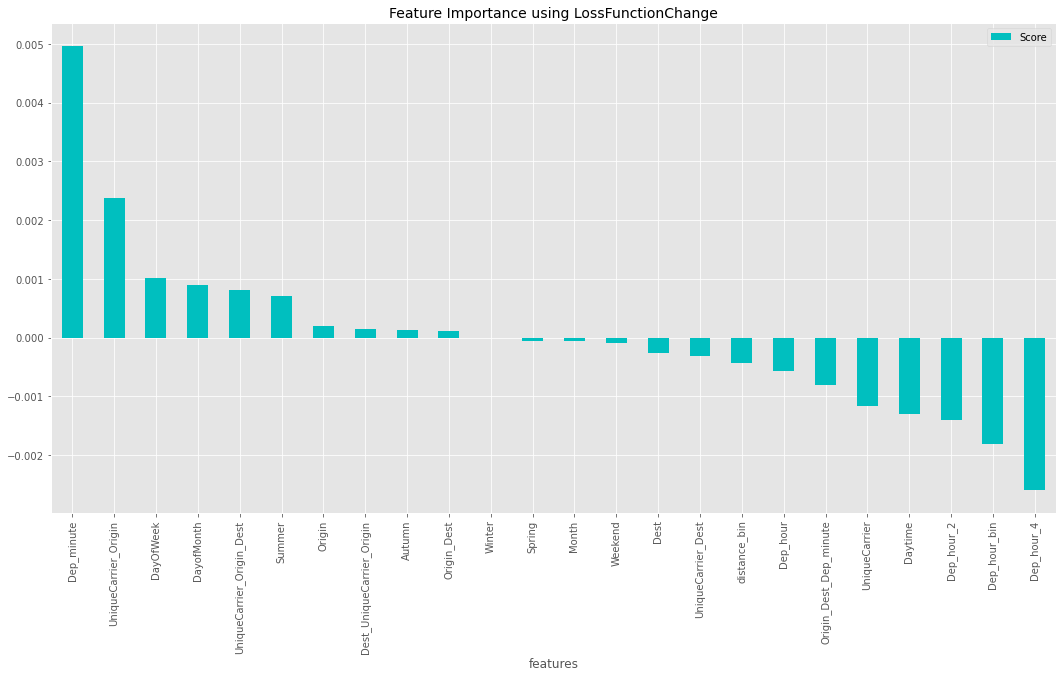

In [493]:
method = 'LossFunctionChange'#'PredictionValuesChange'
fi = ctb.get_feature_importance(Pool(X_valid, label=y_valid, cat_features=cat_feat_idx), type=method)

feature_score = pd.DataFrame(list(zip(train_df.drop(columns_to_drop, axis=1).dtypes.index, fi )), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, 
                                          kind='quicksort', na_position='last')
plt.rcParams["figure.figsize"] = (18,9)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
ax.set_xlabel("features")
plt.show()

Catboost interaction feature importance

In [352]:
fi = ctb.get_feature_importance(Pool(X_valid, label=y_valid, cat_features=cat_feat_idx), type="Interaction")
fi_decoded = []
for k,item in enumerate(fi):  
    first = train_df.drop(columns_to_drop, axis=1).dtypes.index[fi[k][0]]
    second = train_df.drop(columns_to_drop, axis=1).dtypes.index[fi[k][1]]
    if first != second:
        fi_decoded.append([first + "_" + second, fi[k][2]])

fi_decoded[:50]

[['UniqueCarrier_Origin_Dest', 2.8085853772733245],
 ['Origin_Dest_Dep_minute', 2.4488777247335247],
 ['Origin_Dest_Dep_hour', 2.2609800654543943],
 ['Dest_UniqueCarrier_Origin', 1.9121968337058999],
 ['Origin_UniqueCarrier_Dest', 1.8637460171291174],
 ['Origin_Dest_UniqueCarrier_Dest', 1.7848217328582798],
 ['Origin_Dest_Dep_hour_bin', 1.5805497078261856],
 ['Origin_distance_bin', 1.538771178620133],
 ['Dest_distance_bin', 1.4994455241715978],
 ['Dest_Dep_hour_bin', 1.463429059376228],
 ['Month_DayofMonth', 1.3916947406995945],
 ['UniqueCarrier_Dep_minute', 1.329113386831846],
 ['UniqueCarrier_Dep_hour_bin', 1.307856370906315],
 ['Dep_hour_UniqueCarrier_Origin', 1.3026277773869455],
 ['Origin_Dep_hour_bin', 1.2732603436370138],
 ['Dest_Dep_hour', 1.2534218779591944],
 ['UniqueCarrier_Dep_hour', 1.2013374568255863],
 ['Origin_Dest_Daytime', 1.1427127784947115],
 ['UniqueCarrier_Daytime', 1.1422714409832784],
 ['Daytime_UniqueCarrier_Dest', 1.0940989945954003],
 ['distance_bin_UniqueCar

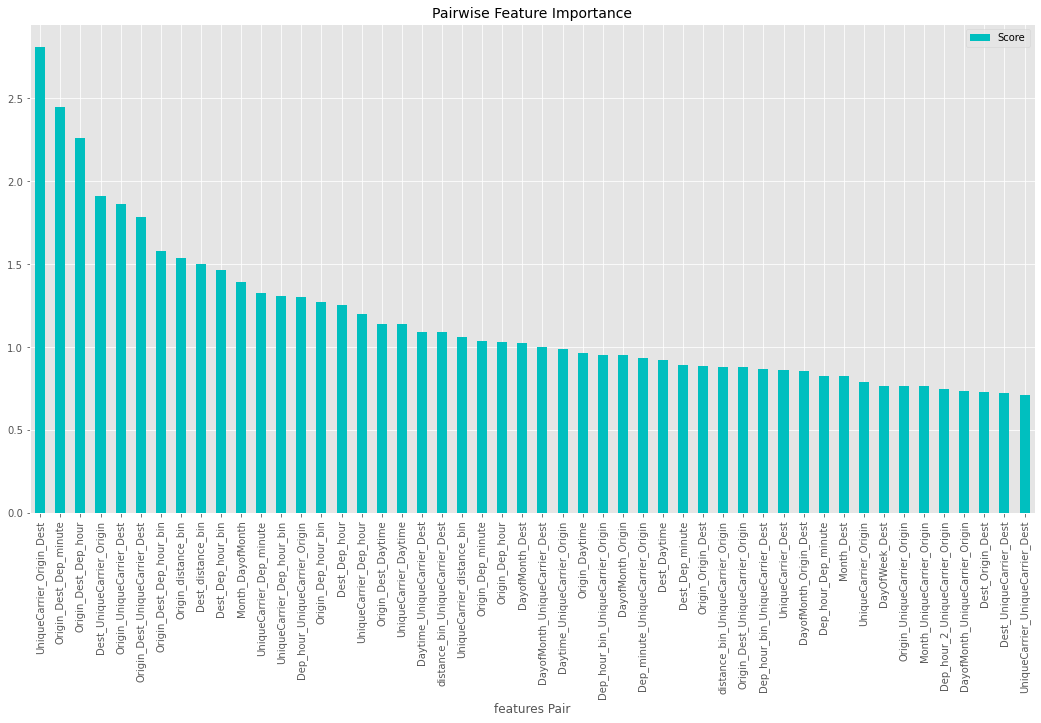

In [353]:
feature_score = pd.DataFrame(fi_decoded[:50],columns=['Feature-Pair','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, 
                                          kind='quicksort', na_position='last')
ax = feature_score.plot('Feature-Pair', 'Score', kind='bar', color='c')
ax.set_title("Pairwise Feature Importance", fontsize = 14)
ax.set_xlabel("features Pair")
plt.show()

Fine tuning model

In [ ]:
iteration = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
roc_auc_scores = []
for i in tqdm(iteration):
    model = CatBoostClassifier(one_hot_max_size = 10, iterations = i)
    model.fit(X_train_part, y_train_part,
    cat_features = categorical_features_indices,
    verbose = False
    )
    roc_auc_scores.append((i, roc_auc_score(y_valid, ctb.predict_proba(X_valid)[:, 1]), 
                              roc_auc_score(y_train_part, ctb.predict_proba(X_train_part)[:, 1]))
#     print(i)

Train on the whole train set, make prediction on the test set

In [494]:
%%time
# ~23 min
ctb.fit(X_train, y_train, cat_features = cat_feat_idx);

Wall time: 20min 9s


In [495]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]
ctb_test_pred

array([0.02049526, 0.02922077, 0.14367201, ..., 0.30576809, 0.11909075,
       0.14590901])

In [496]:
# create submission
file_name = 'catboost_submission_28.csv'
create_submission(ctb_test_pred, file_name)

In [497]:
!head $file_name

id,dep_delayed_15min
0,0.020495261955141283
1,0.02922077046474003
2,0.1436720100585137
3,0.5670522697789457
4,0.23030762180734082
5,0.03624285500339586
6,0.1829610618235192
7,0.4496707817647739
8,0.16188609424543451


Plot validation scores vs. leaderboard scores

In [504]:
valid_scores = [.7697143106015093, .7761791210944395, .7777267353347364, .7653451079072361, .7668237499853245,
                .7612751737671465, .7723618902901401, .7568477375231719, .774466730412704, .7748389710820769, 
                .7800015194055628, .7879981245049293, .8223961100048669, .8011476865355927, .8203784290040302, 
                .8231312279259192, .8266491644585959, .8225516093469518, .8248850438062155, .8300062007557806,
                .8291074490182171, .8276485119776574, .8295914585301511, .8301733965111951, 
                
               ]
lb_scores = [.73807, .73649, .73630, .73605, .73512, .73115, .72794, .73997, .73166, .73117, .73690, .73813, 
             .76240, .74786, .76522, .76517, .76246, .76228, .76377, .76528, .76610, .76303, .76315, .76750,
             
            ]
TOP_SCORES_TO_VIEW = 10

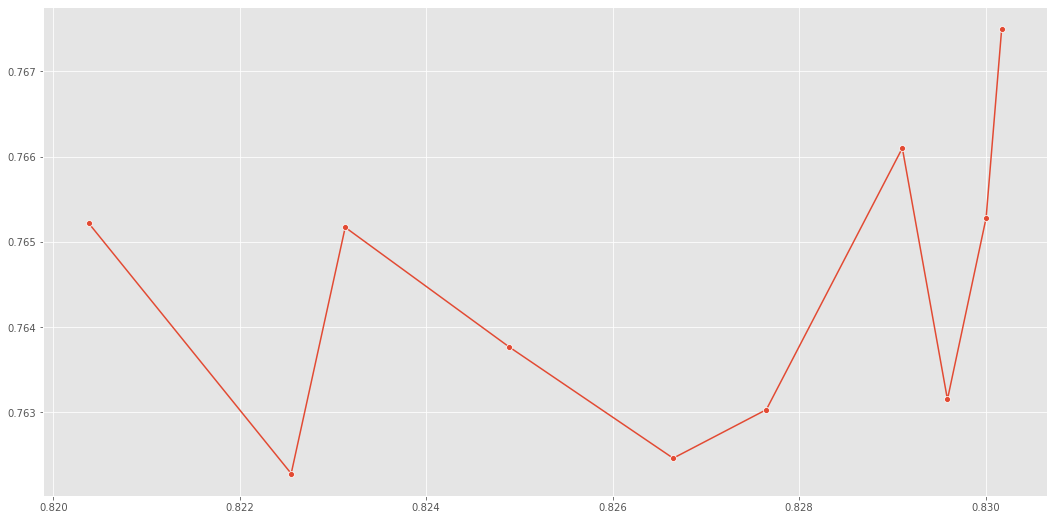

In [505]:
sns.lineplot(x=valid_scores[-TOP_SCORES_TO_VIEW:], y=lb_scores[-TOP_SCORES_TO_VIEW:], marker='o');